In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
def print_dtype_summary(df: pd.DataFrame) -> None:
    """Print data type and missing value summary before cleaning."""
    print("\n[Initial Dataset Info]")
    print(df.dtypes.value_counts())
    print("\n[Column Type Summary]")
    print(df.dtypes)
    print("\n[Missing Values Summary]")
    print(df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False))

def drop_irrelevant_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Drop truly redundant columns."""
    initial_cols = df.shape[1]
    cols_to_drop = ["Unnamed: 0"]
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors="ignore")
    dropped = initial_cols - df.shape[1]
    if dropped > 0:
        print(f"[drop_irrelevant_columns] Dropped {dropped} columns ({(dropped/initial_cols*100):.2f}%).")
    else:
        print("[drop_irrelevant_columns] No redundant columns dropped.")
    return df

def remove_inconsistent_rows(df: pd.DataFrame) -> pd.DataFrame:
    """Remove rows with contradictory information (ie verified bots)."""
    initial_rows = df.shape[0]
    if "verified" in df.columns and "account_type" in df.columns:
        inconsistent_mask = (df['verified'] == True) & (df['account_type'] == 'bot')
        removed = inconsistent_mask.sum()
        df = df.drop(df[inconsistent_mask].index)
        print(f"[remove_inconsistent_rows] Removed {removed} rows ({(removed/initial_rows*100):.2f}%).")
    else:
        print("[remove_inconsistent_rows] Skipped (columns missing).")
    return df

def handle_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """Fill or encode missing values appropriately for EDA."""
    total = df.shape[0]
    
    if "description" in df.columns:
        missing_desc = df["description"].isna().sum()
        df["has_description"] = df["description"].notnull().astype(int)
        df["description"] = df["description"].fillna("NA")
        print(f"[handle_missing_values] Filled {missing_desc} missing descriptions ({(missing_desc/total*100):.2f}%).")
    
    if "lang" in df.columns:
        missing_lang = df["lang"].isna().sum()
        df["lang"] = df["lang"].fillna("unknown")
        print(f"[handle_missing_values] Filled {missing_lang} missing lang values ({(missing_lang/total*100):.2f}%).")
    
    if "location" in df.columns:
        missing_loc = df["location"].isna().sum()
        df["location"] = df["location"].fillna("unknown")
        print(f"[handle_missing_values] Filled {missing_loc} missing locations ({(missing_loc/total*100):.5f}%).")
    
    if "profile_image_url" in df.columns:
        missing_img = df["profile_image_url"].isna().sum()
        df["profile_image_url"] = df["profile_image_url"].fillna("none")
        df["has_profile_img"] = df["profile_image_url"].apply(lambda x: 0 if x == "none" else 1)
        print(f"[handle_missing_values] Filled {missing_img} missing profile_image_url ({(missing_img/total*100):.2f}%).")
    
    if "profile_background_image_url" in df.columns:
        missing_bg = df["profile_background_image_url"].isna().sum()
        df["profile_background_image_url"] = df["profile_background_image_url"].fillna("none")
        df["has_background_img"] = df["profile_background_image_url"].apply(lambda x: 0 if x == "none" else 1)
        print(f"[handle_missing_values] Filled {missing_bg} missing profile_background_image_url ({(missing_bg/total*100):.2f}%).")
    
    return df

def convert_data_types(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure correct datatypes for analysis and EDA."""
    if "created_at" in df.columns:
        df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
        df["account_age_days"] = (pd.Timestamp.now() - df["created_at"]).dt.days
        print("[convert_data_types] Converted 'created_at' to datetime and derived 'account_age_days'.")
    
    # Automatically convert boolean-like and categorical-looking columns
    converted = []
    for col in df.columns:
        if df[col].dtype == "object" and df[col].nunique() < (0.1 * len(df)):
            df[col] = df[col].astype("category")
            converted.append(col)
        elif df[col].dtype == "bool":
            df[col] = df[col].astype("category")
            converted.append(col)
    if converted:
        print(f"[convert_data_types] Converted {len(converted)} columns to categorical: {converted}")
    else:
        print("[convert_data_types] No categorical conversions applied.")
    
    return df

def remove_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure unique identifiers (id, screen_name) and remove duplicates if any."""
    initial_rows = df.shape[0]
    if "id" in df.columns:
        df = df.drop_duplicates(subset="id", keep="first")
    if "screen_name" in df.columns:
        df = df.drop_duplicates(subset="screen_name", keep="first")
    removed = initial_rows - df.shape[0]
    print(f"[remove_duplicates] Removed {removed} duplicate rows ({(removed/initial_rows*100):.2f}%).")
    return df

def clean_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Main cleaning function for pre-EDA preparation."""
    print_dtype_summary(df)
    print(f"\nInitial dataset shape: {df.shape}")
    df = drop_irrelevant_columns(df)
    df = remove_inconsistent_rows(df)
    df = handle_missing_values(df)
    df = convert_data_types(df)
    df = remove_duplicates(df)
    print(f"Final dataset shape: {df.shape}")
    return df

In [3]:
df = pd.read_csv("../data/raw/twitter_human_bots_dataset.csv")
df_cleaned = clean_dataset(df)
df_cleaned.to_csv("../data/cleaned/twitter_human_bots_dataset_cleaned.csv", index=False)



[Initial Dataset Info]
object     8
int64      7
bool       4
float64    1
Name: count, dtype: int64

[Column Type Summary]
Unnamed: 0                        int64
created_at                       object
default_profile                    bool
default_profile_image              bool
description                      object
favourites_count                  int64
followers_count                   int64
friends_count                     int64
geo_enabled                        bool
id                                int64
lang                             object
location                         object
profile_background_image_url     object
profile_image_url                object
screen_name                      object
statuses_count                    int64
verified                           bool
average_tweets_per_day          float64
account_age_days                  int64
account_type                     object
dtype: object

[Missing Values Summary]
lang                            795

In [4]:
# Negative/impossible values
print(df_cleaned[df_cleaned['followers_count'] < 0])
print(df_cleaned[df_cleaned['friends_count'] < 0])
print(df_cleaned[df_cleaned['statuses_count'] < 0])
print(df_cleaned[df_cleaned['favourites_count'] < 0])

# Outliers (follower counts)
print(df_cleaned['followers_count'].describe(percentiles=[0.95, 0.99, 0.999]))

Empty DataFrame
Columns: [created_at, default_profile, default_profile_image, description, favourites_count, followers_count, friends_count, geo_enabled, id, lang, location, profile_background_image_url, profile_image_url, screen_name, statuses_count, verified, average_tweets_per_day, account_age_days, account_type, has_description, has_profile_img, has_background_img]
Index: []

[0 rows x 22 columns]
Empty DataFrame
Columns: [created_at, default_profile, default_profile_image, description, favourites_count, followers_count, friends_count, geo_enabled, id, lang, location, profile_background_image_url, profile_image_url, screen_name, statuses_count, verified, average_tweets_per_day, account_age_days, account_type, has_description, has_profile_img, has_background_img]
Index: []

[0 rows x 22 columns]
Empty DataFrame
Columns: [created_at, default_profile, default_profile_image, description, favourites_count, followers_count, friends_count, geo_enabled, id, lang, location, profile_backgrou


LOADING DATA

Dataset shape: (37122, 22)
Columns: ['created_at', 'default_profile', 'default_profile_image', 'description', 'favourites_count', 'followers_count', 'friends_count', 'geo_enabled', 'id', 'lang', 'location', 'profile_background_image_url', 'profile_image_url', 'screen_name', 'statuses_count', 'verified', 'average_tweets_per_day', 'account_age_days', 'account_type', 'has_description', 'has_profile_img', 'has_background_img']

DATASET OVERVIEW

Total Rows: 37122
Total Columns: 22

Data Types:
created_at                       object
default_profile                    bool
default_profile_image              bool
description                      object
favourites_count                  int64
followers_count                   int64
friends_count                     int64
geo_enabled                        bool
id                                int64
lang                             object
location                         object
profile_background_image_url     object
profile_im

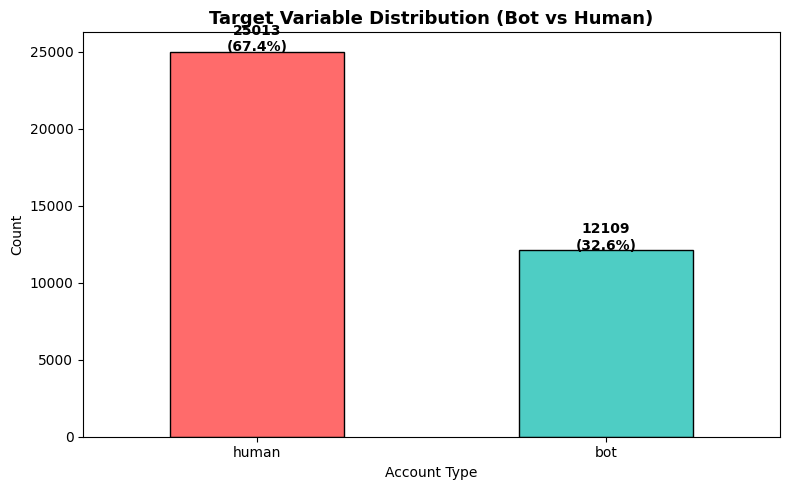


MISSING VALUES ANALYSIS

        Column  Missing_Count  Missing_Percentage
3  description           7251           19.532892

CATEGORICAL FEATURES ANALYSIS


lang:
  Unique values: 49
  Top 5 values:
lang
en         21278
unknown     7949
es          1164
pt           691
it           634
Name: count, dtype: int64

location:
  Unique values: 11970
  Top 5 values:
location
unknown            12971
Los Angeles, CA      517
New York, NY         336
United States        239
Los Angeles          223
Name: count, dtype: int64

description:
  Unique values: 29636
  Top 5 values:
description
Actor                13
.                    13
#BlackLivesMatter    10
:)                    7
hi                    7
Name: count, dtype: int64

screen_name:
  Unique values: 37122
  Top 5 values:
screen_name
zhemcom            1
best_in_dumbest    1
CatholicTweet1     1
_TaisCarvalho_     1
LilyandGia         1
Name: count, dtype: int64

BOOLEAN FEATURES ANALYSIS

                 Feature  True_Count  

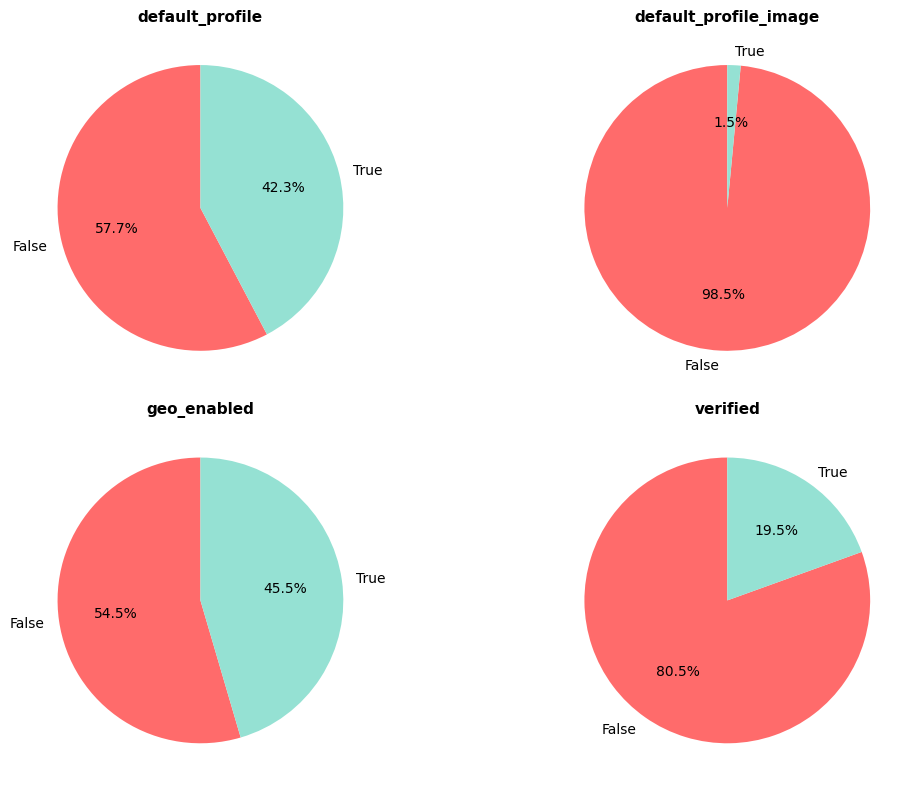


NUMERICAL FEATURES ANALYSIS

                  Feature           Mean    Median           Std     Min           Max   Skewness     Kurtosis
0         followers_count  352883.125020   353.000  2.407388e+06     0.0  1.216415e+08  24.191229   835.758714
1           friends_count    4016.483487   294.000  4.456304e+04     0.0  4.343060e+06  39.129988  2768.538935
2          statuses_count   19890.121464  4116.000  6.339170e+04     0.0  2.771910e+06  17.081253   488.191257
3        favourites_count   12295.350331  2065.000  3.387177e+04     0.0  8.851230e+05   7.859151   102.242926
4  average_tweets_per_day       6.597600     1.457  2.390430e+01     0.0  1.269055e+03  23.850752   909.201993
5        account_age_days    4910.621087  5106.000  1.013187e+03  2378.0  7.054000e+03  -0.535869    -0.756879

NUMERICAL FEATURES DISTRIBUTIONS



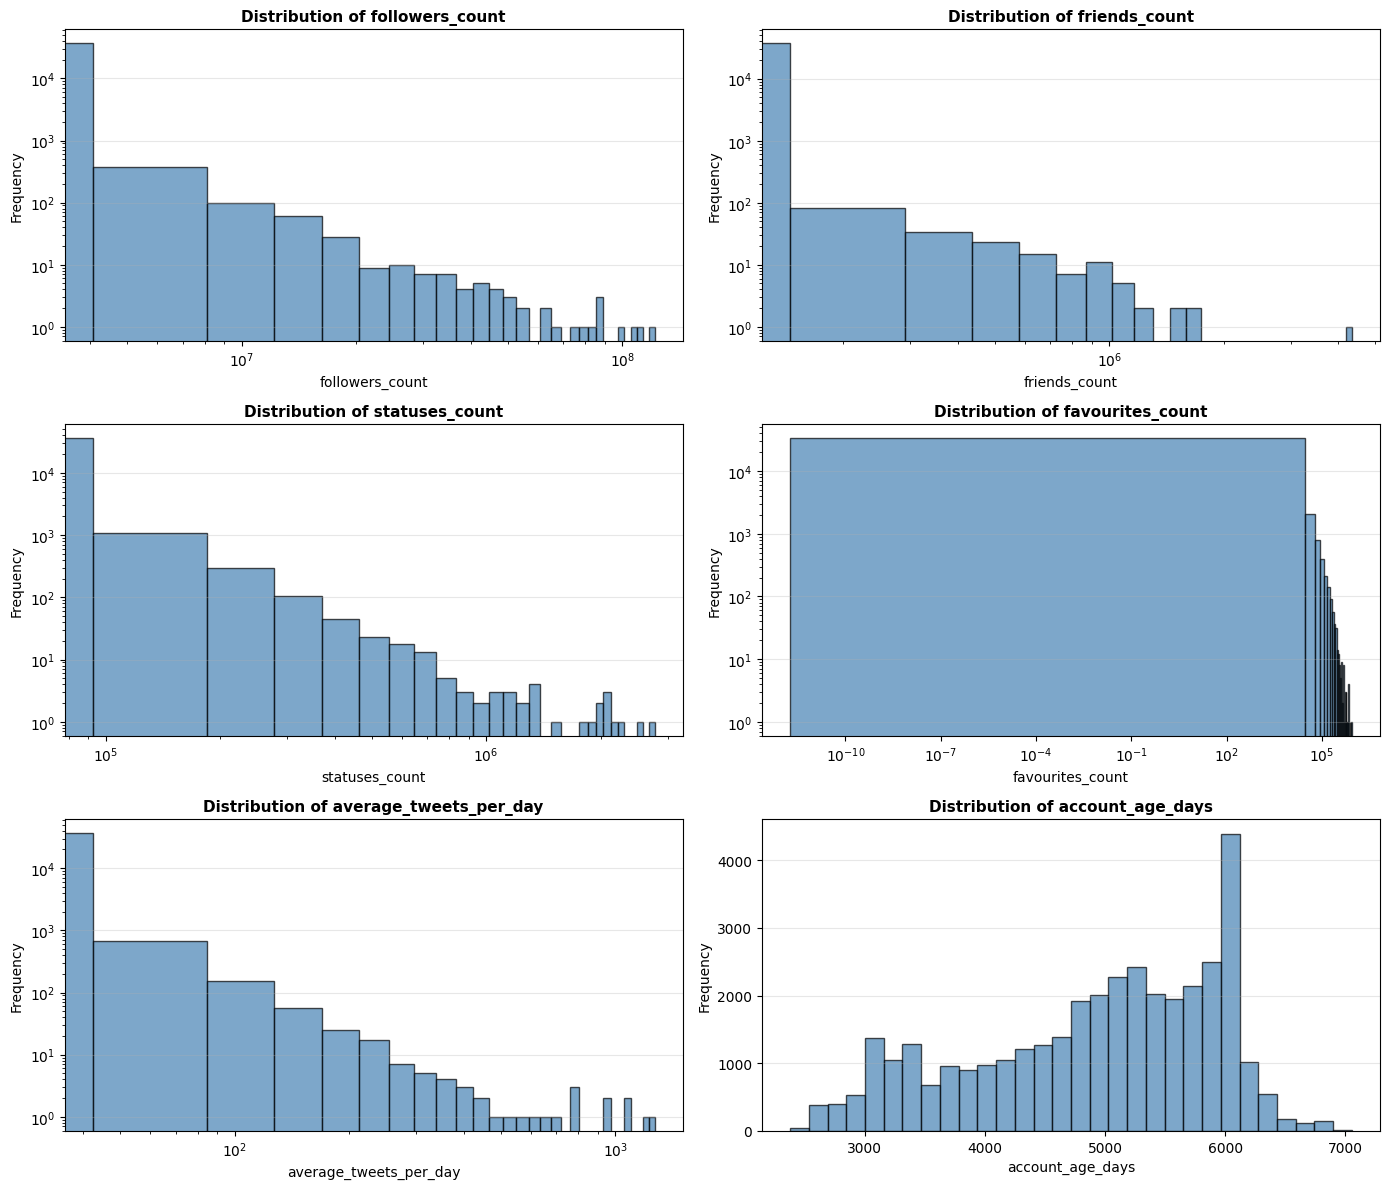


OUTLIER ANALYSIS

                  Feature  Outlier_Count  Outlier_Percentage
0         followers_count           8094           21.803782
1           friends_count           4023           10.837239
2          statuses_count           4441           11.963256
3        favourites_count           5154           13.883950
4  average_tweets_per_day           4425           11.920155
5        account_age_days              0            0.000000

FEATURE BEHAVIOUR: BOTS VS HUMANS



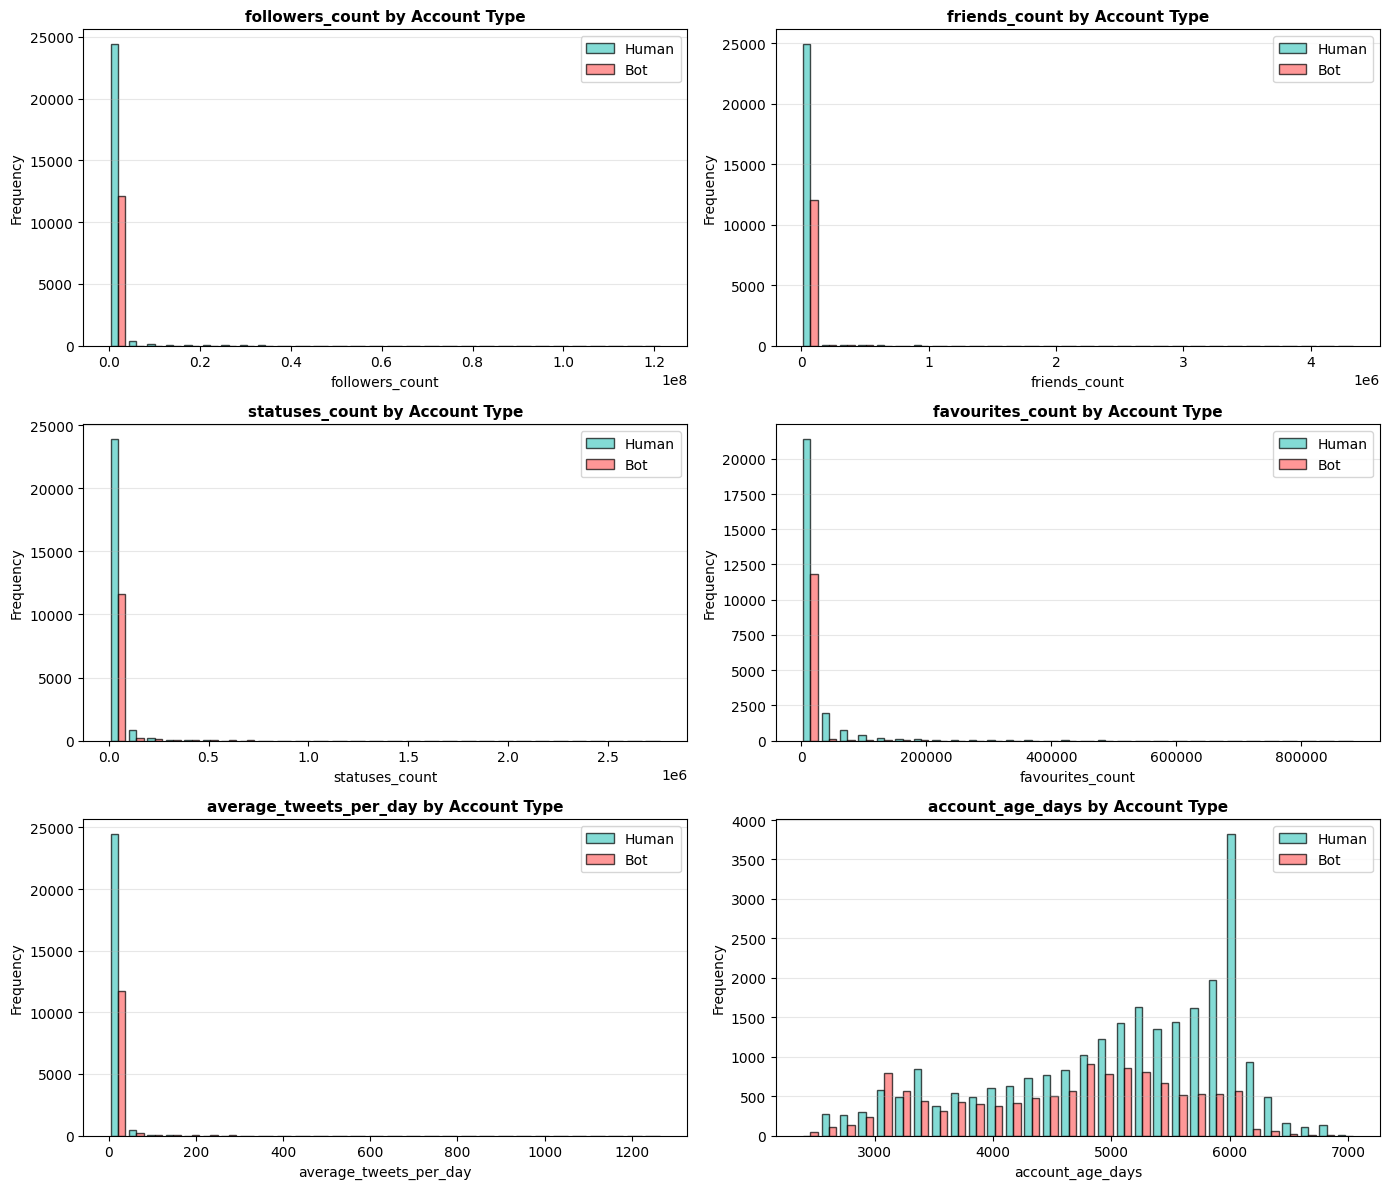


Statistical Comparison (Bots vs Humans):
                  Feature      Bot_Mean     Human_Mean  Mean_Difference        P_Value Significant
0         followers_count  12330.402428  517747.512254   -505417.109826   1.420917e-80         Yes
1           friends_count   3621.660253    4207.620677      -585.960425   2.349479e-01          No
2          statuses_count  16636.424147   21465.263223     -4828.839076   5.871149e-12         Yes
3        favourites_count   4258.515567   16186.048455    -11927.532888  4.564864e-225         Yes
4  average_tweets_per_day      6.360142       6.712556        -0.352414   1.829703e-01          No
5        account_age_days   4583.326947    5069.066885      -485.739938   0.000000e+00         Yes

CORRELATION ANALYSIS



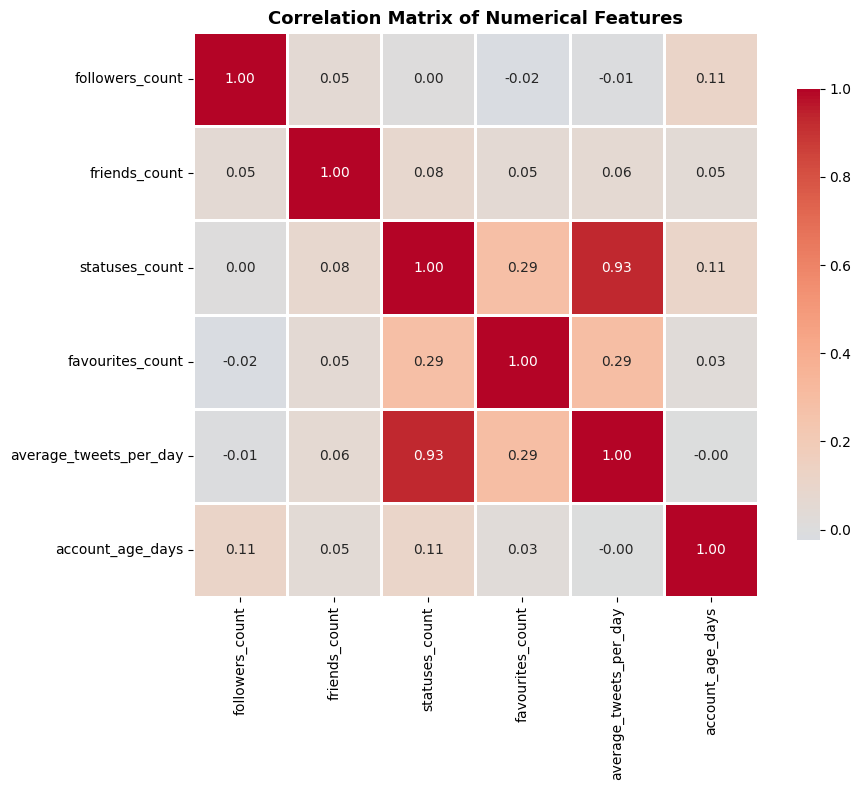

Correlation Matrix:
                        followers_count  friends_count  statuses_count  \
followers_count                1.000000       0.050540        0.004635   
friends_count                  0.050540       1.000000        0.081551   
statuses_count                 0.004635       0.081551        1.000000   
favourites_count              -0.024171       0.051901        0.286440   
average_tweets_per_day        -0.005746       0.058921        0.929440   
account_age_days               0.113330       0.047084        0.105463   

                        favourites_count  average_tweets_per_day  \
followers_count                -0.024171               -0.005746   
friends_count                   0.051901                0.058921   
statuses_count                  0.286440                0.929440   
favourites_count                1.000000                0.288372   
average_tweets_per_day          0.288372                1.000000   
account_age_days                0.025209             

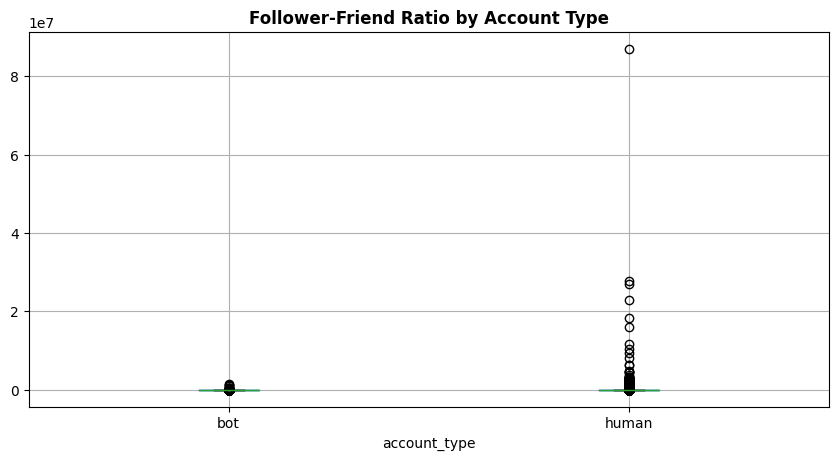

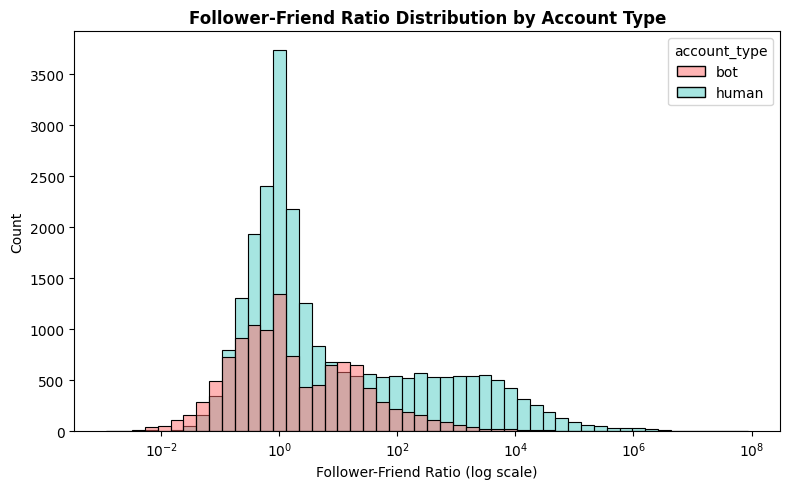


HYPOTHESIS 2: Account Activity Patterns
Hypothesis: Bots show abnormal activity patterns (very high tweets per day
or suspiciously low account age with high activity).

Tweets/day - Bot mean: 6.36, Human mean: 6.71
T-test p-value: 0.30264482 -> Not significant
Account age (days) - Bot mean: 4583.33, Human mean: 5069.07
T-test p-value: 0.00000000 -> Significant


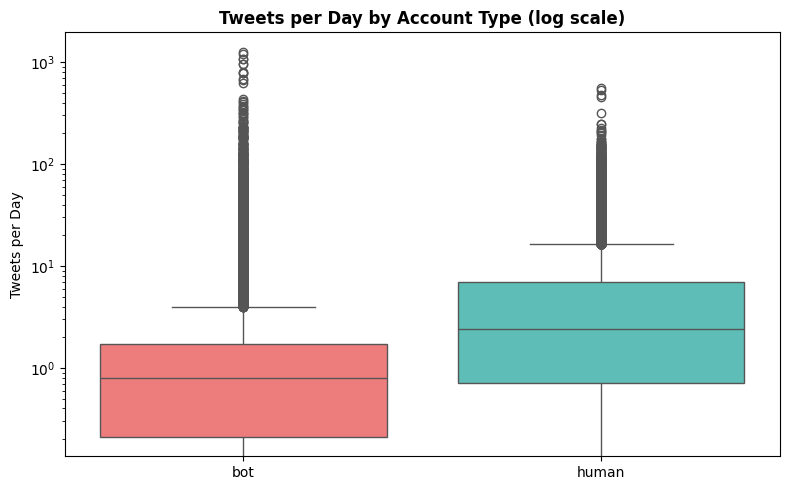

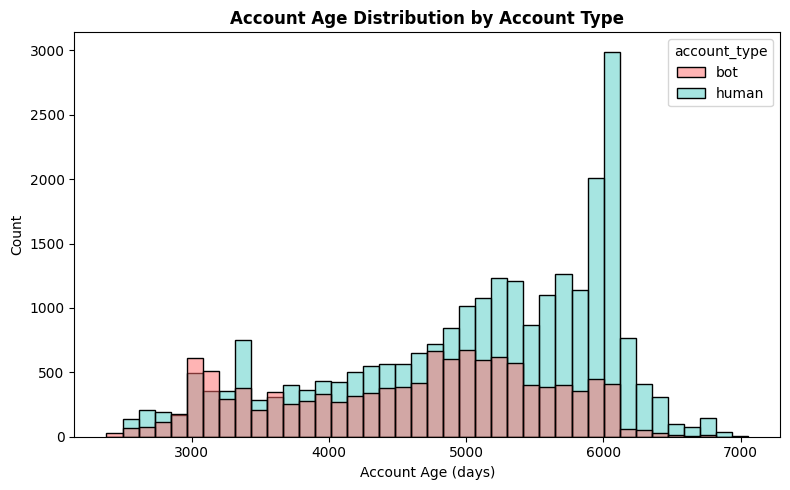


HYPOTHESIS 3: Profile Completeness
Hypothesis: Bot accounts may have incomplete profiles (default profile picture,
no description, no geo-location enabled) compared to humans.

Default profile image - Chi-square p-value: 0.00000000 -> Significant
Has description - Chi-square p-value: 0.00000000 -> Significant
Geo-enabled - Chi-square p-value: 0.00000000 -> Significant


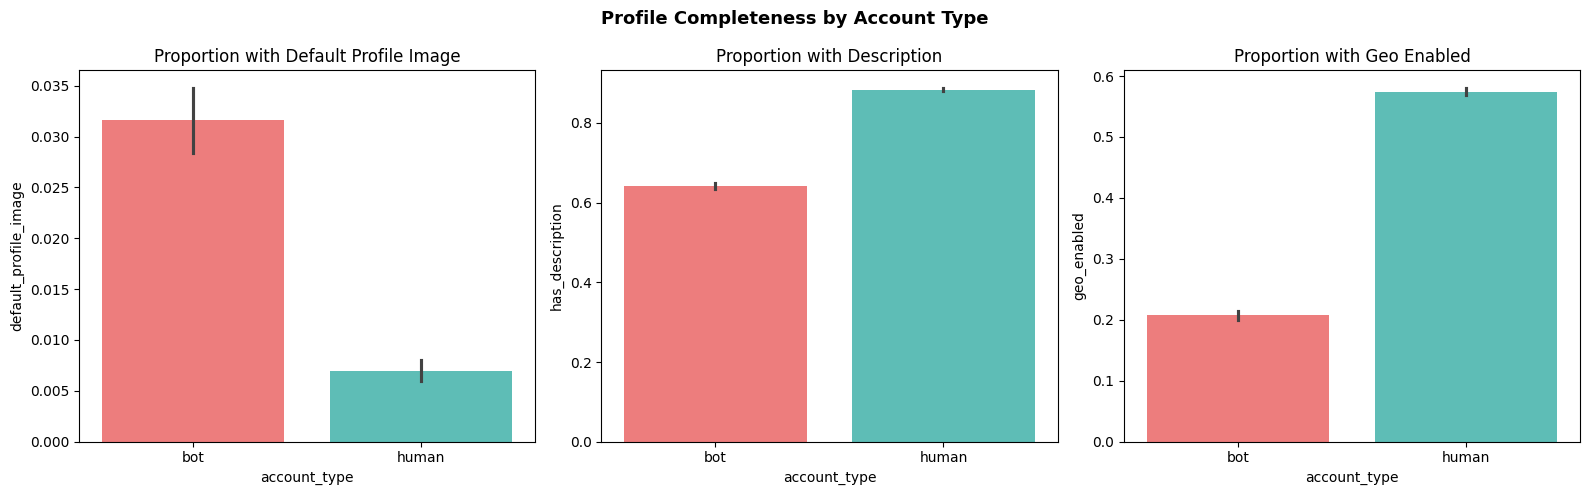


HYPOTHESIS 4: Verification Status
Hypothesis: Verified accounts are overwhelmingly human, not bots.

Verified status - Chi-square p-value: 0.0000 -> Significant
verified      False  True 
account_type              
bot           12109      0
human         17778   7235


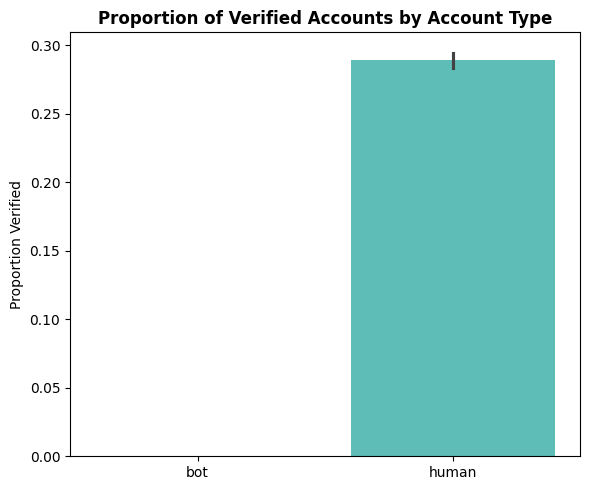


HYPOTHESIS 5: Language Distribution
Hypothesis: Bots disproportionately use English (“en”) or “unknown” language tags compared to humans.

Top 10 languages - Chi-square p-value: 0.0000 -> Significant
lang           af   ar   de     en   es   fr   it   ja   pt  unknown
account_type                                                        
bot           214  360  123   5066  238   92  165  180  193     4485
human         119  216  411  16212  926  271  469  191  498     3464


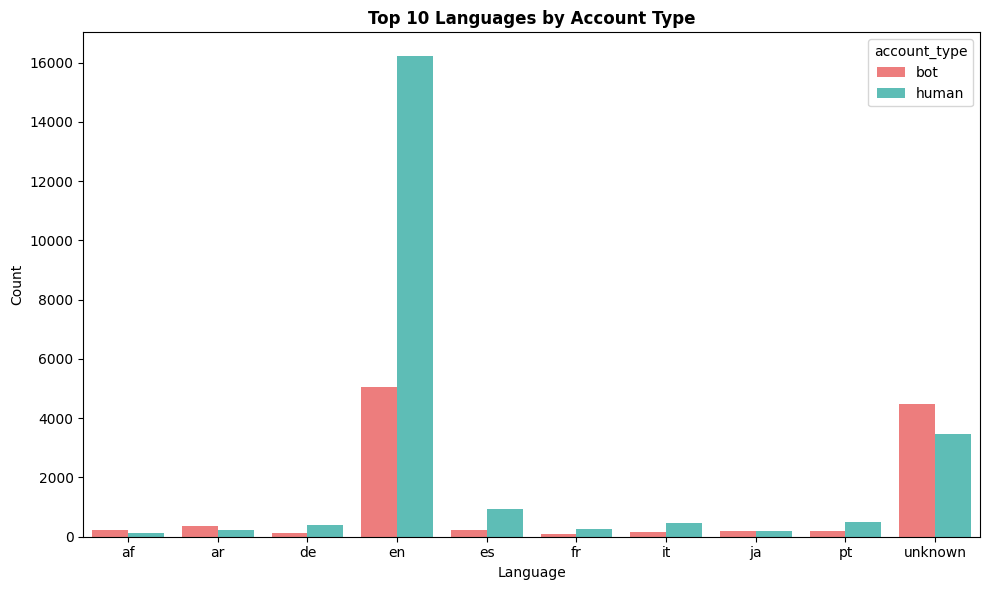


HYPOTHESIS 6: Engagement Ratio
Hypothesis: Bots may tweet a lot but 'like' (favourite) posts less, leading to a lower favourites/tweets ratio than humans.

Bot mean: 2.2906, Human mean: 2.3856
Mean difference: -0.0951
T-test p-value: 0.7868 -> Not significant


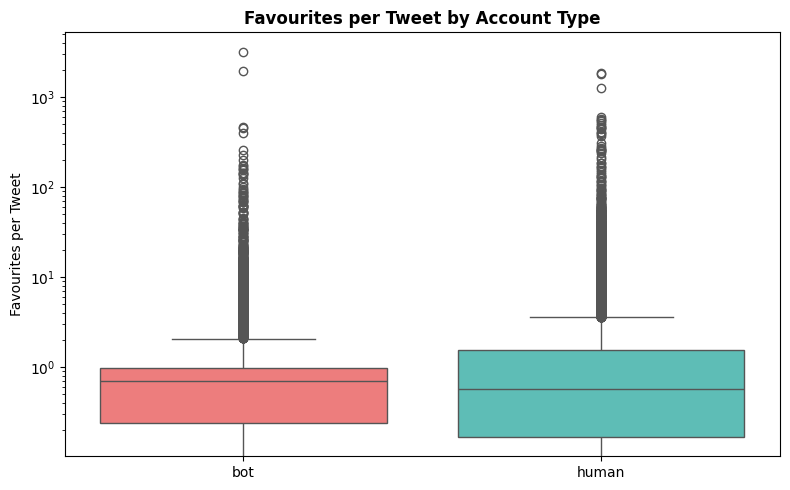


DATA QUALITY SUMMARY

Total Records: 37122
Total Features: 24
Missing Values (%): 0.8138704811163192
Duplicate Rows: 0
Class Balance: {'human': 67.38052906632186, 'bot': 32.619470933678144}

 EDA complete.


In [6]:
# HELPER FUNCTIONS FOR REUSABILITY
def print_section(title):
    """Print formatted section header"""
    print(f"\n{'='*80}")
    print(f"{title.upper()}")
    print(f"{'='*80}\n")

def missing_value_analysis(df):
    """Analyze missing values"""
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': missing.index,
        'Missing_Count': missing.values,
        'Missing_Percentage': missing_pct.values
    }).sort_values('Missing_Percentage', ascending=False)
    return missing_df[missing_df['Missing_Count'] > 0]

def distribution_stats(df, col):
    """Get stats for a column"""
    if df[col].dtype in ['float64', 'int64']:
        return {
            'Mean': df[col].mean(),
            'Median': df[col].median(),
            'Std': df[col].std(),
            'Min': df[col].min(),
            'Max': df[col].max(),
            'Skewness': df[col].skew(),
            'Kurtosis': df[col].kurtosis()
        }

def plot_distribution(df, col, ax, bins=30, log_scale=False):
    """Plot histogram with optional log scale"""
    ax.hist(df[col].dropna(), bins=bins, edgecolor='black', alpha=0.7, color='steelblue')
    ax.set_title(f'Distribution of {col}', fontweight='bold', fontsize=11)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    if log_scale:
        ax.set_yscale('log')
    ax.grid(axis='y', alpha=0.3)

def plot_boxplot(df, col, ax):
    """Plot boxplot with outlier info"""
    bp = ax.boxplot(df[col].dropna(), vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    ax.set_title(f'Boxplot of {col}', fontweight='bold', fontsize=11)
    ax.set_ylabel(col)
    ax.grid(axis='y', alpha=0.3)
    
    # Calculate outliers
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    return len(outliers)

# LOAD DATA
print_section("Loading Data")
df = pd.read_csv("../data/cleaned/twitter_human_bots_dataset_cleaned.csv")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# DATASET OVERVIEW
print_section("Dataset Overview")
print(f"Total Rows: {len(df)}")
print(f"Total Columns: {len(df.columns)}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# TARGET VARIABLE ANALYSIS (account_type)
print_section("Target Variable Analysis: account_type")
target_counts = df['account_type'].value_counts()
target_pct = (target_counts / len(df)) * 100
print(f"Account Type Distribution:\n{pd.DataFrame({'Count': target_counts, 'Percentage': target_pct})}")

# Visualize class imbalance
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
colors = ['#FF6B6B', '#4ECDC4']
target_counts.plot(kind='bar', ax=ax, color=colors, edgecolor='black')
ax.set_title('Target Variable Distribution (Bot vs Human)', fontweight='bold', fontsize=13)
ax.set_ylabel('Count')
ax.set_xlabel('Account Type')
plt.xticks(rotation=0)
for i, v in enumerate(target_counts):
    ax.text(i, v + 50, f'{v}\n({target_pct[i]:.1f}%)', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# MISSING VALUES ANALYSIS
print_section("Missing Values Analysis")
missing_df = missing_value_analysis(df)
if len(missing_df) > 0:
    print(missing_df)
else:
    print("No missing values detected!")

# CATEGORICAL FEATURES ANALYSIS
print_section("Categorical Features Analysis")

categorical_cols = ['lang', 'location', 'description', 'screen_name']
for col in categorical_cols:
    print(f"\n{col}:")
    print(f"  Unique values: {df[col].nunique()}")
    print(f"  Top 5 values:\n{df[col].value_counts().head()}")

# BOOLEAN FEATURES ANALYSIS
print_section("Boolean Features Analysis")

bool_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
bool_data = []
for col in bool_cols:
    true_count = (df[col] == True).sum()
    false_count = (df[col] == False).sum()
    true_pct = (true_count / len(df)) * 100
    bool_data.append({
        'Feature': col,
        'True_Count': true_count,
        'False_Count': false_count,
        'True_Percentage': true_pct
    })

bool_df = pd.DataFrame(bool_data)
print(bool_df)

# Visualize boolean features
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for idx, col in enumerate(bool_cols):
    val_counts = df[col].value_counts()
    axes[idx].pie([val_counts[False], val_counts[True]], 
                   labels=['False', 'True'], 
                   autopct='%1.1f%%',
                   colors=['#FF6B6B', '#95E1D3'],
                   startangle=90)
    axes[idx].set_title(col, fontweight='bold', fontsize=11)
plt.tight_layout()
plt.show()

# NUMERICAL FEATURES ANALYSIS
print_section("Numerical Features Analysis")

numerical_cols = ['followers_count', 'friends_count', 'statuses_count', 
                  'favourites_count', 'average_tweets_per_day', 'account_age_days']

stats_data = []
for col in numerical_cols:
    stats_data.append({
        'Feature': col,
        **distribution_stats(df, col)
    })

stats_df = pd.DataFrame(stats_data)
print(stats_df.to_string())

# DISTRIBUTION PLOTS FOR NUMERICAL FEATURES
print_section("Numerical Features Distributions")

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    # Check if log scale needed (high skewness)
    skewness = df[col].skew()
    log_scale = skewness > 2
    
    plot_distribution(df, col, axes[idx], log_scale=log_scale)
    if log_scale:
        axes[idx].set_xscale('log')

plt.tight_layout()
plt.show()

# OUTLIER ANALYSIS
print_section("Outlier Analysis")

outlier_summary = []
for col in numerical_cols:
    fig, ax = plt.subplots(figsize=(8, 4))
    n_outliers = plot_boxplot(df, col, ax)
    outlier_pct = (n_outliers / len(df)) * 100
    outlier_summary.append({
        'Feature': col,
        'Outlier_Count': n_outliers,
        'Outlier_Percentage': outlier_pct
    })


plt.close('all')
outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df)

# RELATIONSHIP WITH TARGET (BOTS vs HUMANS)

print_section("Feature Behaviour: Bots vs Humans")

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    bot_data = df[df['account_type'] == 'bot'][col]
    human_data = df[df['account_type'] == 'human'][col]
    
    axes[idx].hist([human_data, bot_data], label=['Human', 'Bot'], 
                   bins=30, edgecolor='black', alpha=0.7, color=['#4ECDC4', '#FF6B6B'])
    axes[idx].set_title(f'{col} by Account Type', fontweight='bold', fontsize=11)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison
print("\nStatistical Comparison (Bots vs Humans):")
comparison_data = []
for col in numerical_cols:
    bot_vals = df[df['account_type'] == 'bot'][col]
    human_vals = df[df['account_type'] == 'human'][col]
    
    # T-test
    t_stat, p_value = stats.ttest_ind(bot_vals, human_vals)
    
    comparison_data.append({
        'Feature': col,
        'Bot_Mean': bot_vals.mean(),
        'Human_Mean': human_vals.mean(),
        'Mean_Difference': bot_vals.mean() - human_vals.mean(),
        'P_Value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string())

# CORRELATION ANALYSIS
print_section("Correlation Analysis")

# Prepare numeric data for correlation
df_numeric = df[numerical_cols].copy()
correlation_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

print("Correlation Matrix:")
print(correlation_matrix)

# FEATURE ENGINEERING INSIGHTS
print_section("Feature Engineering Insights & Hypotheses")

print("""
HYPOTHESIS 1: Follower-Friend Ratio
Hypothesis: Bot accounts may have disproportionate follower-to-friend ratios
(either very high followers with few friends, or vice versa).
""")

df['follower_friend_ratio'] = df['followers_count'] / (df['friends_count'] + 1)

bot_vals = df[df['account_type']=='bot']['follower_friend_ratio']
human_vals = df[df['account_type']=='human']['follower_friend_ratio']

t_stat, p_val = stats.ttest_ind(bot_vals, human_vals, equal_var=False)

print(f"Bot mean: {bot_vals.mean():.2f}, Human mean: {human_vals.mean():.2f}")
print(f"Mean difference: {bot_vals.mean() - human_vals.mean():.2f}")
print(f"T-test p-value: {p_val:.8f} -> {'Significant' if p_val < 0.05 else 'Not significant'}")

fig, ax = plt.subplots(figsize=(10, 5))
df.boxplot(column='follower_friend_ratio', by='account_type', ax=ax)
ax.set_title('Follower-Friend Ratio by Account Type', fontweight='bold')
plt.suptitle('')
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(data=df, x="follower_friend_ratio", hue="account_type",
             bins=50, kde=False, log_scale=(True, False), 
             palette={"human": "#4ECDC4", "bot": "#FF6B6B"}, ax=ax)
ax.set_title("Follower-Friend Ratio Distribution by Account Type", fontweight="bold")
ax.set_xlabel("Follower-Friend Ratio (log scale)")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

print("""
HYPOTHESIS 2: Account Activity Patterns
Hypothesis: Bots show abnormal activity patterns (very high tweets per day
or suspiciously low account age with high activity).
""")

# Tweets per day
bot_vals = df[df['account_type']=='bot']['average_tweets_per_day']
human_vals = df[df['account_type']=='human']['average_tweets_per_day']
t_stat, p_val = stats.ttest_ind(bot_vals, human_vals, equal_var=False)

print(f"Tweets/day - Bot mean: {bot_vals.mean():.2f}, Human mean: {human_vals.mean():.2f}")
print(f"T-test p-value: {p_val:.8f} -> {'Significant' if p_val < 0.05 else 'Not significant'}")

# Account age
bot_vals = df[df['account_type']=='bot']['account_age_days']
human_vals = df[df['account_type']=='human']['account_age_days']
t_stat, p_val = stats.ttest_ind(bot_vals, human_vals, equal_var=False)

print(f"Account age (days) - Bot mean: {bot_vals.mean():.2f}, Human mean: {human_vals.mean():.2f}")
print(f"T-test p-value: {p_val:.8f} -> {'Significant' if p_val < 0.05 else 'Not significant'}")

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df, x="account_type", y="average_tweets_per_day",
            palette={"human": "#4ECDC4", "bot": "#FF6B6B"}, ax=ax)
ax.set_yscale("log")
ax.set_title("Tweets per Day by Account Type (log scale)", fontweight="bold")
ax.set_ylabel("Tweets per Day")
ax.set_xlabel("")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(data=df, x="account_age_days", hue="account_type",
             bins=40, palette={"human": "#4ECDC4", "bot": "#FF6B6B"}, ax=ax)
ax.set_title("Account Age Distribution by Account Type", fontweight="bold")
ax.set_xlabel("Account Age (days)")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

print("""
HYPOTHESIS 3: Profile Completeness
Hypothesis: Bot accounts may have incomplete profiles (default profile picture,
no description, no geo-location enabled) compared to humans.
""")

# Default profile image (chi-square test)
contingency = pd.crosstab(df['account_type'], df['default_profile_image'])
chi2, p_val, _, _ = stats.chi2_contingency(contingency)
print(f"Default profile image - Chi-square p-value: {p_val:.8f} -> {'Significant' if p_val < 0.05 else 'Not significant'}")

# Has description
contingency = pd.crosstab(df['account_type'], df['has_description'])
chi2, p_val, _, _ = stats.chi2_contingency(contingency)
print(f"Has description - Chi-square p-value: {p_val:.8f} -> {'Significant' if p_val < 0.05 else 'Not significant'}")

# Geo enabled
if 'geo_enabled' in df.columns:
    contingency = pd.crosstab(df['account_type'], df['geo_enabled'])
    chi2, p_val, _, _ = stats.chi2_contingency(contingency)
    print(f"Geo-enabled - Chi-square p-value: {p_val:.8f} -> {'Significant' if p_val < 0.05 else 'Not significant'}")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
sns.barplot(x="account_type", y="default_profile_image", data=df,
            estimator=lambda x: sum(x)/len(x), ax=axes[0],
            palette={"human": "#4ECDC4", "bot": "#FF6B6B"})
axes[0].set_title("Proportion with Default Profile Image")

sns.barplot(x="account_type", y="has_description", data=df,
            estimator=lambda x: sum(x)/len(x), ax=axes[1],
            palette={"human": "#4ECDC4", "bot": "#FF6B6B"})
axes[1].set_title("Proportion with Description")

sns.barplot(x="account_type", y="geo_enabled", data=df,
            estimator=lambda x: sum(x)/len(x), ax=axes[2],
            palette={"human": "#4ECDC4", "bot": "#FF6B6B"})
axes[2].set_title("Proportion with Geo Enabled")

plt.suptitle("Profile Completeness by Account Type", fontweight="bold", fontsize=13)
plt.tight_layout()
plt.show()

# =====================================================================
# HYPOTHESIS 4: Verification Status
# =====================================================================
print("""
HYPOTHESIS 4: Verification Status
Hypothesis: Verified accounts are overwhelmingly human, not bots.
""")

if "verified" in df.columns:
    contingency = pd.crosstab(df['account_type'], df['verified'])
    chi2, p_val, _, _ = stats.chi2_contingency(contingency)
    print(f"Verified status - Chi-square p-value: {p_val:.4f} -> {'Significant' if p_val < 0.05 else 'Not significant'}")
    print(contingency)

    fig, ax = plt.subplots(figsize=(6, 5))
    sns.barplot(x="account_type", y="verified", data=df,
                estimator=lambda x: sum(x)/len(x),
                palette={"human": "#4ECDC4", "bot": "#FF6B6B"}, ax=ax)
    ax.set_title("Proportion of Verified Accounts by Account Type", fontweight="bold")
    ax.set_ylabel("Proportion Verified")
    ax.set_xlabel("")
    plt.tight_layout()
    plt.show()


# =====================================================================
# HYPOTHESIS 5: Language Distribution
# =====================================================================
print("""
HYPOTHESIS 5: Language Distribution
Hypothesis: Bots disproportionately use English (“en”) or “unknown” language tags compared to humans.
""")

if "lang" in df.columns:
    top_langs = df['lang'].value_counts().nlargest(10).index
    contingency = pd.crosstab(df[df['lang'].isin(top_langs)]['account_type'],
                              df[df['lang'].isin(top_langs)]['lang'])
    chi2, p_val, _, _ = stats.chi2_contingency(contingency)
    print(f"Top 10 languages - Chi-square p-value: {p_val:.4f} -> {'Significant' if p_val < 0.05 else 'Not significant'}")
    print(contingency)

    fig, ax = plt.subplots(figsize=(10, 6))
    lang_counts = df[df['lang'].isin(top_langs)].groupby(['account_type','lang']).size().reset_index(name='count')
    sns.barplot(data=lang_counts, x="lang", y="count", hue="account_type",
                palette={"human": "#4ECDC4", "bot": "#FF6B6B"}, ax=ax)
    ax.set_title("Top 10 Languages by Account Type", fontweight="bold")
    ax.set_xlabel("Language")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()


# =====================================================================
# HYPOTHESIS 6: Engagement Ratio (Favourites per Tweet)
# =====================================================================
print("""
HYPOTHESIS 6: Engagement Ratio
Hypothesis: Bots may tweet a lot but 'like' (favourite) posts less, leading to a lower favourites/tweets ratio than humans.
""")

df['favourites_per_tweet'] = df['favourites_count'] / (df['statuses_count'] + 1)

bot_vals = df[df['account_type']=='bot']['favourites_per_tweet']
human_vals = df[df['account_type']=='human']['favourites_per_tweet']

t_stat, p_val = stats.ttest_ind(bot_vals, human_vals, equal_var=False)

print(f"Bot mean: {bot_vals.mean():.4f}, Human mean: {human_vals.mean():.4f}")
print(f"Mean difference: {bot_vals.mean() - human_vals.mean():.4f}")
print(f"T-test p-value: {p_val:.4f} -> {'Significant' if p_val < 0.05 else 'Not significant'}")

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df, x="account_type", y="favourites_per_tweet",
            palette={"human": "#4ECDC4", "bot": "#FF6B6B"}, ax=ax)
ax.set_title("Favourites per Tweet by Account Type", fontweight="bold")
ax.set_ylabel("Favourites per Tweet")
ax.set_xlabel("")
ax.set_yscale("log")  # log scale because ratio is heavy-tailed
plt.tight_layout()
plt.show()

# DATA QUALITY SUMMARY

print_section("Data Quality Summary")

quality_report = {
    'Total Records': len(df),
    'Total Features': len(df.columns),
    'Missing Values (%)': (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100,
    'Duplicate Rows': df.duplicated().sum(),
    'Class Balance': target_pct.to_dict(),
}

for key, value in quality_report.items():
    print(f"{key}: {value}")

print("\n EDA complete.")